# Introduction
In this notebook, we will explore **Vacuum World agents** as introduced in Russell & Norvig.

You will:
- Understand the *PEAS framework* (Performance, Environment, Actuators, Sensors).
- Implement and run different types of agents (Reflex, Model-based, Goal-based, Utility-based).
- Observe visually how each agent behaves in the environment.
- Compare their performance using reward plots.
- Extend the code by completing TODO exercises.

This is notebook is solved by *Dino Meng* (SM3201466)


# Vacuum World — Agent Types
Reflex / Model-based / Goal-based / Utility-based agents acting in a simple grid environment.
- We will NOT cover learning agents

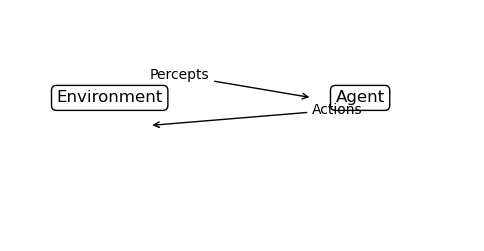

In [1]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3)); plt.axis('off')
plt.text(0.1, 0.6, 'Environment', fontsize=12, bbox=dict(boxstyle='round', fc='white'))
plt.text(0.7, 0.6, 'Agent', fontsize=12, bbox=dict(boxstyle='round', fc='white'))
plt.annotate('Percepts', xy=(0.65,0.62), xytext=(0.3,0.7), arrowprops=dict(arrowstyle='->'))
plt.annotate('Actions', xy=(0.3,0.5), xytext=(0.65,0.55), arrowprops=dict(arrowstyle='->'))
plt.show()

In [2]:
import random

ACTIONS = ['Up','Down','Left','Right','Suck','NoOp']

class VacuumEnvironment:
    def __init__(self, width=4, height=3, dirt_prob=0.4, seed=0):
        random.seed(seed)
        self.width, self.height = width, height
        self.dirt = {(x,y) for x in range(width) for y in range(height) if random.random()<dirt_prob}
        self.agent_pos = (0, 0)
        self.total_reward = 0
        self.t = 0
 
    def in_bounds(self, pos) -> bool:
        x,y = pos
        return 0 <= x < self.width and 0 <= y < self.height
 
    def percept(self):
        x,y = self.agent_pos
        return {'location': (x,y), 'dirty': (x,y) in self.dirt}
 
    def step(self, action) -> int:
        reward = -1
        x,y = self.agent_pos
        if action == 'Suck':
            if (x,y) in self.dirt:
                self.dirt.remove((x,y))
                reward += 10
        elif action == 'Left':
            new = (x-1, y)
            if self.in_bounds(new): self.agent_pos = new
        elif action == 'Right':
            new = (x+1, y)
            if self.in_bounds(new): self.agent_pos = new
        elif action == 'Up':
            new = (x, y+1)
            if self.in_bounds(new): self.agent_pos = new
        elif action == 'Down':
            new = (x, y-1)
            if self.in_bounds(new): self.agent_pos = new
        
        self.total_reward += reward
        self.t += 1
        return reward
    
    def is_done(self) -> bool:
        return len(self.dirt)==0

def render(env: VacuumEnvironment):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(4,3))
    ax = plt.gca()
    ax.set_xlim(-0.5, env.width-0.5)
    ax.set_ylim(-0.5, env.height-0.5)
    ax.set_xticks(range(env.width))
    ax.set_yticks(range(env.height))
    ax.grid(True)
    
    for (x,y) in env.dirt:
        ax.text(x, y, '•', ha='center', va='center', fontsize=16)
    
    ax.text(env.agent_pos[0], env.agent_pos[1], 'A', ha='center', va='center', fontsize=16)
    ax.invert_yaxis()
    ax.set_title(f"t={env.t} reward={env.total_reward}")
    plt.show()

In [3]:
class ReflexVacuumAgent:
    def act(self, percept):
        if percept['dirty']: return 'Suck'
        x,y = percept['location']

        return 'Right' if y%2==0 else 'Left'

class ModelBasedVacuumAgent:
    # has some memory, defined in the __init__ function
    def __init__(self,w,h): 
        self.w = w
        self.h = h
        self.cleaned = set()

    def act(self, percept):
        x,y=percept['location']
        if percept['dirty']: self.cleaned.add((x,y)); return 'Suck'
        self.cleaned.add((x,y))
        unseen=[(i,j) for i in range(self.w) for j in range(self.h) if (i,j) not in self.cleaned]

        if not unseen: return 'NoOp'
        tx,ty=min(unseen, key=lambda p: abs(p[0]-x)+abs(p[1]-y))

        if tx>x: return 'Right'
        if tx<x: return 'Left'
        if ty>y: return 'Up'
        if ty<y: return 'Down'

        return 'NoOp'

class GoalBasedVacuumAgent:
    # it also makes some sort of plan to collect dirty collection faster
    def __init__(self): 
        self.plan = []

    def shortest_path(self,start,goal,w,h):
        from collections import deque
        q=deque([start]); prev={start:None}
        while q:
            u=q.popleft(); x,y=u
            if u==goal: break
            for v,a in [((x+1,y),'Right'),((x-1,y),'Left'),((x,y+1),'Up'),((x,y-1),'Down')]:
                if 0<=v[0]<w and 0<=v[1]<h and v not in prev:
                    prev[v]=(u,a); q.append(v)
        if goal not in prev: return []
        acts=[]; cur=goal
        while prev[cur] is not None:
            cur,a=prev[cur]; acts.append(a)
        return list(reversed(acts))
   
    def act(self, percept, env):
        x,y=percept['location']
        if percept['dirty']: return 'Suck'
        if not self.plan:
            if not env.dirt: return 'NoOp'
            target=min(env.dirt, key=lambda p: abs(p[0]-x)+abs(p[1]-y))
            self.plan=self.shortest_path((x,y), target, env.width, env.height)
        return self.plan.pop(0) if self.plan else 'NoOp'

class UtilityBasedVacuumAgent:
    # well defined utility function, takes everything into account (what did it do, ...)

    def act(self, percept, env):
        x,y=percept['location']
        candidates=['Suck','Up','Down','Left','Right','NoOp']
        
        def next_pos(a):
            if a=='Left': return (max(0,x-1),y)
            if a=='Right': return (min(env.width-1,x+1),y)
            if a=='Up': return (x,min(env.height-1,y+1))
            if a=='Down': return (x,max(0,y-1))
            return (x,y)
        
        def score(a):
            s=-1
            if a=='Suck' and (x,y) in env.dirt: s+=10
            nx,ny=next_pos(a)
            dist=min((abs(nx-dx)+abs(ny-dy) for (dx,dy) in env.dirt), default=0)
            return s - dist
        
        return max(candidates, key=score)
    

# four different implementations of vacuum agents

In [16]:
def render_ascii(env):
    rows=[]
    for y in range(env.height):
        row=[]
        for x in range(env.width):
            if (x,y)==env.agent_pos: row.append('A')
            elif (x,y) in env.dirt: row.append('X')
            else: row.append('·')
        rows.append(' '.join(row))
    print('\n'.join(rows)); print(f"t={env.t} total_reward={env.total_reward}\n")
    
def snapshot(env, title=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(4,3)); ax=plt.gca()
    ax.set_xlim(-0.5, env.width-0.5); ax.set_ylim(-0.5, env.height-0.5)
    ax.set_xticks(range(env.width)); ax.set_yticks(range(env.height)); ax.grid(True)
    for (x,y) in env.dirt: ax.text(x,y,'•',ha='center',va='center',fontsize=16)
    ax.text(env.agent_pos[0], env.agent_pos[1], 'A', ha='center', va='center', fontsize=16)
    ax.invert_yaxis(); ax.set_title(title or f"t={env.t} reward={env.total_reward}")
    plt.show()

def demo_agent(agent, steps=8, width=4, height=3, dirt_prob=0.5, seed=7, use_ascii=True, use_plot=True):
    env=VacuumEnvironment(width,height,dirt_prob,seed)
    name=type(agent).__name__
    if use_ascii: print(f"=== {name} ===\nInitial:"); render_ascii(env)
    if use_plot: snapshot(env, title=f"{name} — initial")
    for i in range(1,steps+1):
        p=env.percept()
        if isinstance(agent, (GoalBasedVacuumAgent, UtilityBasedVacuumAgent)): a=agent.act(p, env)
        else: a=agent.act(p)
        env.step(a)
        if use_ascii: print(f"Step {i}: {a}"); render_ascii(env)
        if use_plot: snapshot(env, title=f"{name} — step {i}: {a}")
        if env.is_done(): print('All clean — ended early.'); break

demo_agent(ReflexVacuumAgent(), steps=6, use_plot=False)


=== ReflexVacuumAgent ===
Initial:
A X X X
X · · X
· X X X
t=0 total_reward=0

Step 1: Suck
A X X X
X · · X
· X X X
t=1 total_reward=9

Step 2: Right
· A X X
X · · X
· X X X
t=2 total_reward=8

Step 3: Suck
· A X X
X · · X
· X X X
t=3 total_reward=17

Step 4: Right
· · A X
X · · X
· X X X
t=4 total_reward=16

Step 5: Suck
· · A X
X · · X
· X X X
t=5 total_reward=25

Step 6: Right
· · · A
X · · X
· X X X
t=6 total_reward=24



In [17]:
demo_agent(ModelBasedVacuumAgent(4,3), steps=6, use_plot=False)


=== ModelBasedVacuumAgent ===
Initial:
A X X X
X · · X
· X X X
t=0 total_reward=0

Step 1: Suck
A X X X
X · · X
· X X X
t=1 total_reward=9

Step 2: Up
· X X X
A · · X
· X X X
t=2 total_reward=8

Step 3: Suck
· X X X
A · · X
· X X X
t=3 total_reward=17

Step 4: Up
· X X X
· · · X
A X X X
t=4 total_reward=16

Step 5: Right
· X X X
· · · X
· A X X
t=5 total_reward=15

Step 6: Suck
· X X X
· · · X
· A X X
t=6 total_reward=24



In [18]:
demo_agent(GoalBasedVacuumAgent(), steps=6,use_plot=False)


=== GoalBasedVacuumAgent ===
Initial:
A X X X
X · · X
· X X X
t=0 total_reward=0

Step 1: Suck
A X X X
X · · X
· X X X
t=1 total_reward=9

Step 2: Up
· X X X
A · · X
· X X X
t=2 total_reward=8

Step 3: Suck
· X X X
A · · X
· X X X
t=3 total_reward=17

Step 4: Right
· X X X
· A · X
· X X X
t=4 total_reward=16

Step 5: Up
· X X X
· · · X
· A X X
t=5 total_reward=15

Step 6: Suck
· X X X
· · · X
· A X X
t=6 total_reward=24



In [19]:
demo_agent(UtilityBasedVacuumAgent(), steps=6, use_plot=False)

=== UtilityBasedVacuumAgent ===
Initial:
A X X X
X · · X
· X X X
t=0 total_reward=0

Step 1: Suck
A X X X
X · · X
· X X X
t=1 total_reward=9

Step 2: Up
· X X X
A · · X
· X X X
t=2 total_reward=8

Step 3: Suck
· X X X
A · · X
· X X X
t=3 total_reward=17

Step 4: Up
· X X X
· · · X
A X X X
t=4 total_reward=16

Step 5: Right
· X X X
· · · X
· A X X
t=5 total_reward=15

Step 6: Suck
· X X X
· · · X
· A X X
t=6 total_reward=24



## TODOs
Here are some exercises to try:
1. **Compare Agents**: Run each agent for a fixed horizon and compare total reward.
- Fix timesteps

2. **Modify Reflex Agent**: make it move vertically instead of horizontally.
3. **Enhance Model-Based Agent**: allow it to remember which squares are dirty again if they re-dirty.
4. **Extend Goal-Based Agent**: make it plan a full tour of all squares instead of just nearest dirt.
5. **Tune Utility-Based Agent**: change the scoring function to prefer fewer moves over more reward.
6. **(Optional)** Implement a Learning Agent that improves based on repeated runs (e.g., learns dirt probability).


## Exercise 1

In [111]:

agents = {
    'reflex': ReflexVacuumAgent(),
    'model-based': ModelBasedVacuumAgent(4,3),
    'goal-based': GoalBasedVacuumAgent(),
    'utility-based': UtilityBasedVacuumAgent()
}

global names #todo: improve this part
names = ['reflex', 'model-based', 'goal-based', 'utility-based']

def collect_data(nsteps=10, w=4, h=3, dirt_prob = .5, seed=42):
    data = {}

    for type in names: 
        data[type] = []

        env = VacuumEnvironment(w, h, dirt_prob, seed)
        agent = agents[type]

        for i in range(0, nsteps):
            p = env.percept()
            if isinstance(agent, (GoalBasedVacuumAgent, UtilityBasedVacuumAgent)): a=agent.act(p, env)
            else: a=agent.act(p)
            env.step(a)
            data[type].append(env.total_reward)
            if env.is_done(): print('All clean — ended early.'); 

    return data

data_5 = collect_data(nsteps=5)
data_10 = collect_data(nsteps=10)
data_30 = collect_data(nsteps=20)



All clean — ended early.
All clean — ended early.
All clean — ended early.
All clean — ended early.
All clean — ended early.
All clean — ended early.
All clean — ended early.
All clean — ended early.
All clean — ended early.
All clean — ended early.


In [112]:
import matplotlib.pyplot as plt 
import numpy as np

In [113]:
datas = [data_5, data_10, data_30]
ns = ["5", "10", "20"]

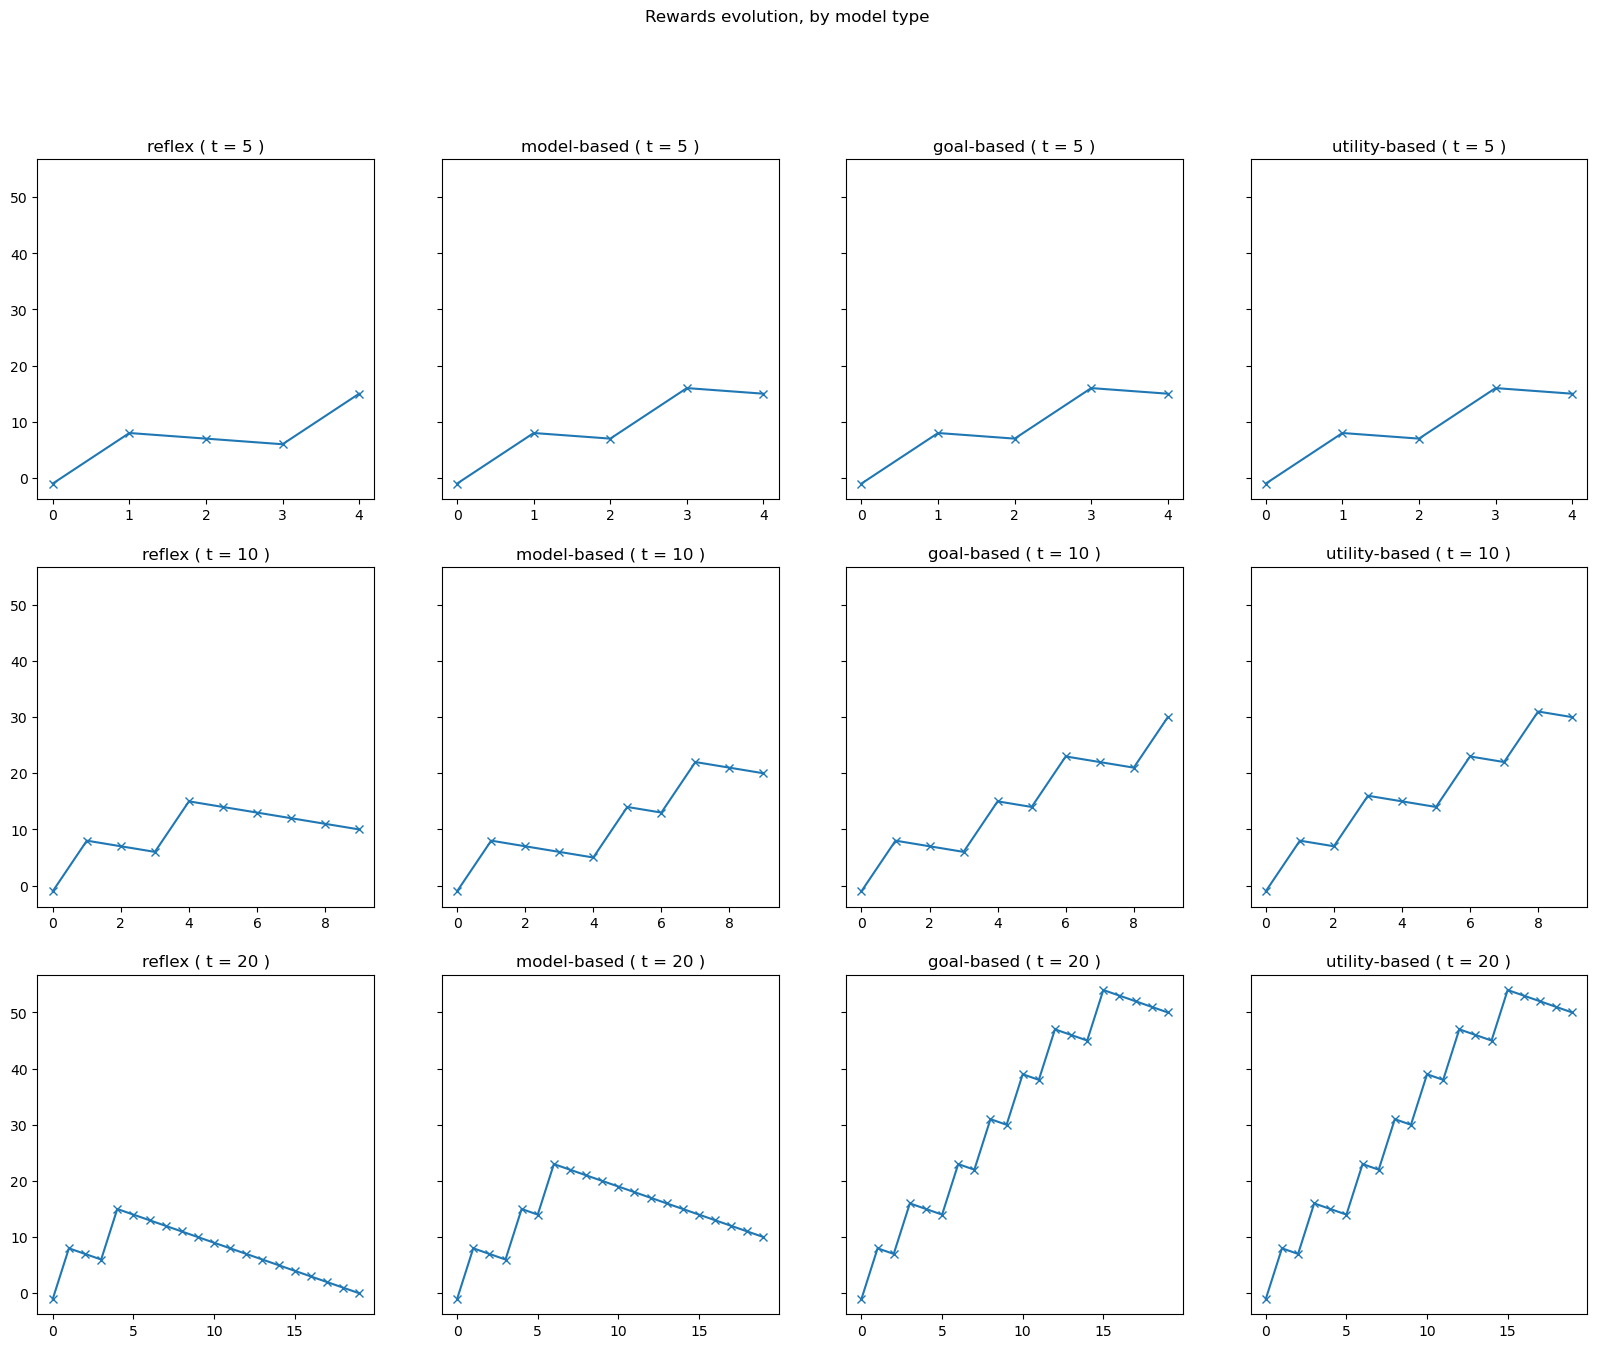

In [116]:
fig, axes = plt.subplots(3, 4, sharey=True, figsize = (20, 15))

i = 0
j = 0

for n in range(3):
    for m in range(4):

        name = names[i]
        axes[n, m].plot(datas[j][name], marker='x')
        axes[n, m].set_title(name + " ( " + "t = " + ns[j] + " )")
        
        i += 1
        i = i % 4

    j += 1

plt.suptitle('Rewards evolution, by model type')
plt.show()

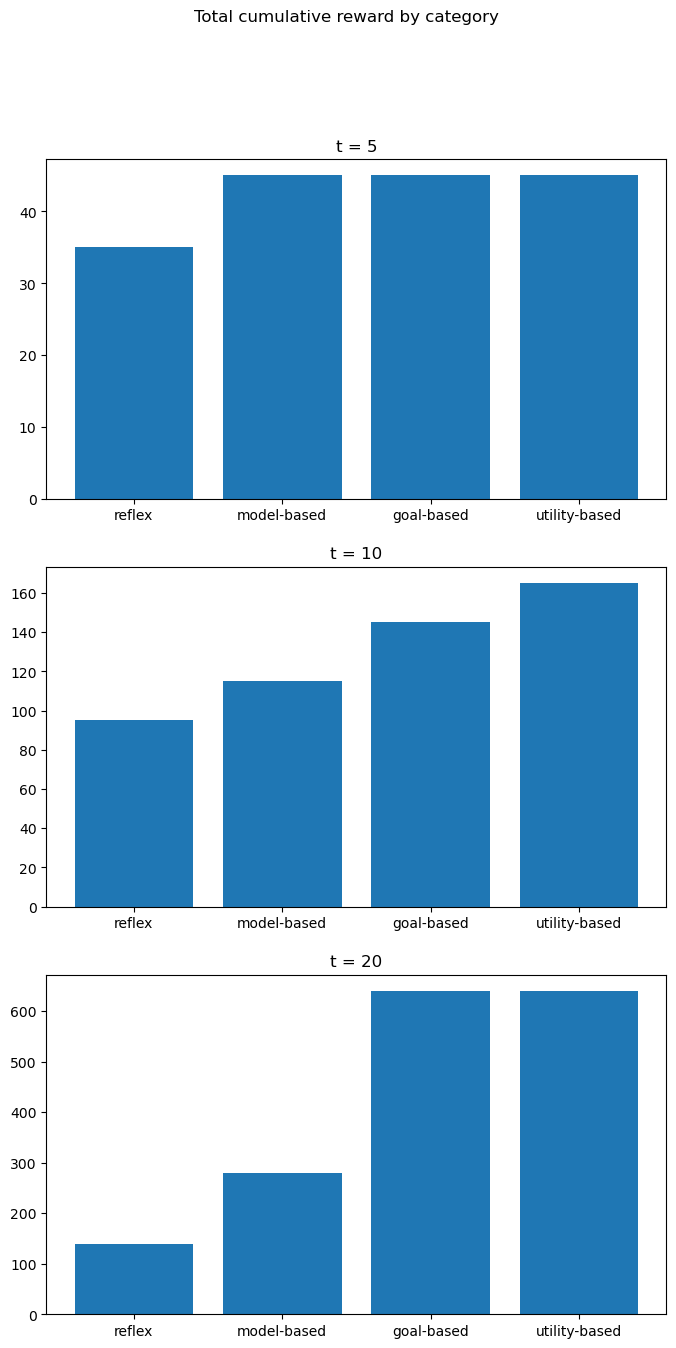

In [120]:

totals_5 = {}
totals_10 = {}
totals_30 = {}


for name in names:
    totals_5[name] = np.sum(data_5[name])
    totals_10[name] = np.sum(data_10[name])
    totals_30[name] = np.sum(data_30[name])

totals = [totals_5, totals_10, totals_30]

fig, axes = plt.subplots(3, 1, figsize=(8, 15))



for n in range(3):


    axes[n].bar(totals[n].keys(), totals[n].values()) # pyright: ignore[reportArgumentType]
    axes[n].set_title(f"t = {ns[n]}")
    fig.suptitle("Total cumulative reward by category")

plt.show()

For small $t$, all of the models work "fairly well"; however, by increasing it we can see the goal-based and utility-based methods work better

## Exercise 2

In [ ]:
class ReflexVacuumAgent_alt(ReflexVacuumAgent):
    def act(self, percept):
        if percept['dirty']: return 'Suck'
        x,y = percept['location']

        return 'Up' if y%2==0 else 'Down'
    


=== ReflexVacuumAgent_alt ===
Initial:
A X X X
X · · X
· X X X
t=0 total_reward=0



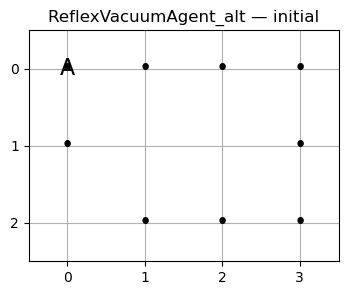

Step 1: Suck
A X X X
X · · X
· X X X
t=1 total_reward=9



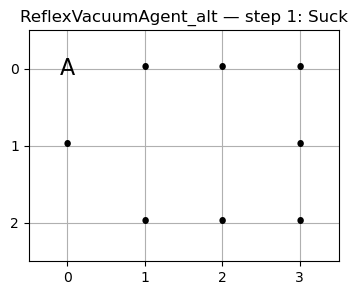

Step 2: Up
· X X X
A · · X
· X X X
t=2 total_reward=8



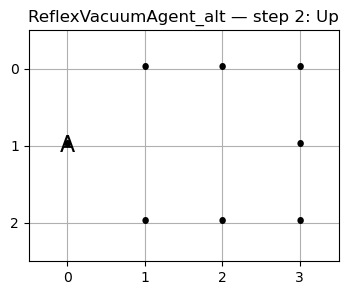

Step 3: Suck
· X X X
A · · X
· X X X
t=3 total_reward=17



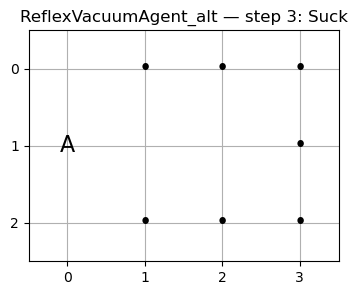

Step 4: Down
A X X X
· · · X
· X X X
t=4 total_reward=16



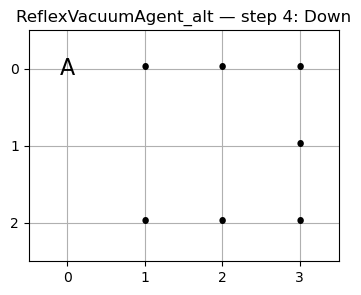

Step 5: Up
· X X X
A · · X
· X X X
t=5 total_reward=15



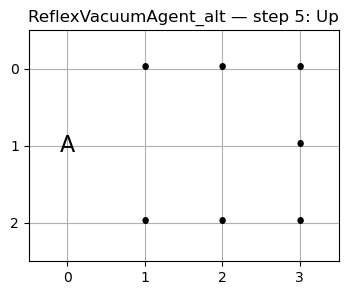

Step 6: Down
A X X X
· · · X
· X X X
t=6 total_reward=14



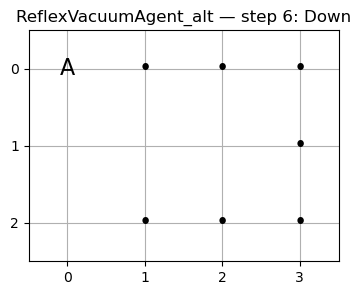

Step 7: Up
· X X X
A · · X
· X X X
t=7 total_reward=13



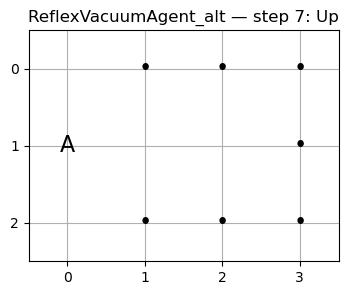

Step 8: Down
A X X X
· · · X
· X X X
t=8 total_reward=12



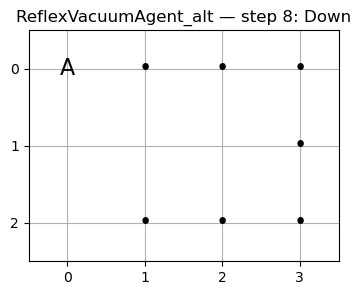

In [131]:
demo_agent(ReflexVacuumAgent_alt())

## Exercise 3

In [175]:
from itertools import product
# Step 1: Modify environment so tiles can get dirty again 
class VacuumEnvironment:
    def __init__(self, width=4, height=3, dirt_prob=0.4, redirt_prob = 0.01, seed=0):
        self.redirt_prob = redirt_prob
        random.seed(seed)
        self.width, self.height = width, height
        self.dirt = {(x,y) for x in range(width) for y in range(height) if random.random()<dirt_prob}
        self.agent_pos = (0, 0)
        self.total_reward = 0
        self.t = 0
 
    def in_bounds(self, pos) -> bool:
        x,y = pos
        return 0 <= x < self.width and 0 <= y < self.height
 
    def percept(self):
        x,y = self.agent_pos
        return {'location': (x,y), 
                'dirty': (x,y) in self.dirt, 
                'dirty_spots': self.dirt
                }
 
    def step(self, action) -> int:
        reward = -1
        x,y = self.agent_pos
        
        if action == 'Suck':
            if (x,y) in self.dirt:
                self.dirt.remove((x,y))
                reward += 10
        
        elif action == 'Left':
            new = (x-1, y)
            if self.in_bounds(new): self.agent_pos = new
        elif action == 'Right':
            new = (x+1, y)
            if self.in_bounds(new): self.agent_pos = new
        elif action == 'Up':
            new = (x, y+1)
            if self.in_bounds(new): self.agent_pos = new
        elif action == 'Down':
            new = (x, y-1)
            if self.in_bounds(new): self.agent_pos = new
        
        if random.random() < self.redirt_prob:
            self.dirt.add((random.randint(0, self.width-1), random.randint(0, self.height-1))) 


        self.total_reward += reward
        self.t += 1

        return reward
    
    def is_done(self) -> bool:
        return len(self.dirt)==0

In [176]:
# Step 2: modify the model-based agent. All I have to do is remove the newly-added dirty spots
class ModelBasedVacuumAgent:
    def __init__(self,w,h): 
        self.w = w
        self.h = h
        self.cleaned = set()

    def act(self, percept):
        
        x,y=percept['location']

        # checks for new dirty spots, by doing intersection between percept['dirty_spots'] and self.cleaned
        new_spots = self.cleaned.intersection(percept['dirty_spots'])
        for spot in new_spots:
            self.cleaned.add(spot)
            print(" ==== NEW DIRTY SPOT FOUND ==== ")

        if percept['dirty']: self.cleaned.add((x,y)); return 'Suck'
        self.cleaned.add((x,y))
        unseen=[(i,j) for i in range(self.w) for j in range(self.h) if (i,j) not in self.cleaned]

        if not unseen: return 'NoOp'
        tx,ty=min(unseen, key=lambda p: abs(p[0]-x)+abs(p[1]-y))

        if tx>x: return 'Right'
        if tx<x: return 'Left'
        if ty>y: return 'Up'
        if ty<y: return 'Down'

        return 'NoOp'



In [177]:
demo_agent(ModelBasedVacuumAgent(4, 3), use_plot=False)

=== ModelBasedVacuumAgent ===
Initial:
A X · ·
· · X ·
X X X ·
t=0 total_reward=0

Step 1: Up
· X · ·
A · X ·
X X X ·
t=1 total_reward=-1

Step 2: Up
· X · ·
· X X ·
A X X ·
t=2 total_reward=-2

Step 3: Suck
· X · ·
· X X ·
A X X ·
t=3 total_reward=7

 ==== NEW DIRTY SPOT FOUND ==== 
Step 4: Suck
· X · ·
X X X ·
A X X ·
t=4 total_reward=16

 ==== NEW DIRTY SPOT FOUND ==== 
Step 5: Right
· X · ·
X X X ·
· A X ·
t=5 total_reward=15

 ==== NEW DIRTY SPOT FOUND ==== 
Step 6: Suck
· X X ·
X X X ·
· A X ·
t=6 total_reward=24

 ==== NEW DIRTY SPOT FOUND ==== 
Step 7: Down
X X X ·
X A X ·
· · X ·
t=7 total_reward=23

 ==== NEW DIRTY SPOT FOUND ==== 
 ==== NEW DIRTY SPOT FOUND ==== 
Step 8: Suck
X X X ·
X A X ·
· · X X
t=8 total_reward=32



## Exercise 5

## Exercise 6

## Exercise 7
We will use Monte Carlo